# **initials**

In [23]:
!cp -r drive/MyDrive/ml_project ./ml_project

In [24]:
# Import the necessary modules
from osgeo import gdal
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import time

# Open the GeoTIFF files using GDAL
datasetTrainingGT = gdal.Open('ml_project/S2A_MSIL1C_20220516_Train_GT.tif')

# Read the data from the first GeoTIFF file into a NumPy array
trainGT2d = datasetTrainingGT.ReadAsArray()
trainGT2d = np.swapaxes(trainGT2d, 0, 1)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
trainGT1d = trainGT2d.reshape(trainGT2d.shape[0] * trainGT2d.shape[1], 1)

# Convert the combined array into a Pandas DataFrame
dfTrainLabels = pd.DataFrame(trainGT1d)

# Export the DataFrame as a CSV file
# dfTrainLabels.to_csv('train.csv', index=False)
np.save('train_gt.npy', trainGT1d)

datasetTraining = gdal.Open('ml_project/S2A_MSIL1C_20220516_TrainingData.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTraing = datasetTraining.ReadAsArray()
dataTraing = np.swapaxes(dataTraing, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTraining1d = dataTraing.reshape(dataTraing.shape[0] * dataTraing.shape[1], -1)
dfTrain = pd.DataFrame(dataTraining1d)

final_data = pd.concat([dfTrainLabels, dfTrain])

train_label_data = pd.concat([dfTrainLabels, dfTrain], axis=1)
train_label_data.columns=['Code', 'Blue', 'Green', 'Red', 'NIR']
train_label_data.to_csv('train.csv')

np.save('train.npy', dataTraining1d)


datasetTest = gdal.Open('ml_project/S2B_MSIL1C_20220528_Test.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTest2d = datasetTest.ReadAsArray()
dataTest2d = np.swapaxes(dataTest2d, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTest1d = dataTest2d.reshape(dataTest2d.shape[0] * dataTest2d.shape[1], -1)
np.save('test_all.npy', dataTest1d)
# Convert the combined array into a Pandas DataFrame
dfTest = pd.DataFrame(dataTest1d)
dfTest.columns=['Blue', 'Green', 'Red', 'NIR']
# Export the DataFrame as a CSV file
dfTest.to_csv('test.csv')

# **remove data with 0**

In [25]:
#remove 0's
zero_row_indices = np.argwhere(~dataTraining1d.any(axis=1))
np_train = dataTraining1d[dataTraining1d != 0]
np_train_gt = np.delete(np.ravel(trainGT1d), zero_row_indices, axis=0)
np_train = np_train.reshape(965708, 4)

# **divide 10000**

In [26]:
np_train = np_train.astype(float) / 10000
dataTest1d = dataTest1d.astype(float) / 10000

# **remove outliers**

knn and bayes are used for this. i compare the predicitons with results and removed the ones which, are not same as the labels.

In [27]:
clf_knn = KNeighborsClassifier(n_neighbors=39)
clf_knn.fit(np_train, np_train_gt)
predictions_knn = clf_knn.predict(np_train)

mask = predictions_knn != np_train_gt
# Apply the mask to the labels and train arrays
f_train_gt = np_train_gt[~mask]
f_train = np_train[~mask]
f_train.shape

(874743, 4)

In [28]:
clf_bayes = GaussianNB()
clf_bayes.fit(f_train, f_train_gt)
predictions_bayes = clf_bayes.predict(f_train)

mask = predictions_bayes != f_train_gt
# Apply the mask to the labels and train arrays
f_train_gt = f_train_gt[~mask]
f_train = f_train[~mask]
f_train.shape

(831958, 4)

In [7]:
clf_rf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

clf_rf.fit(f_train, f_train_gt)
predictions_rf = clf_rf.predict(f_train)

mask = predictions_knn != f_train_gt
# Apply the mask to the labels and train arrays
f_train_gt = f_train_gt[~mask]
f_train = f_train[~mask]

<ipython-input-7-c5bb61540cde>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask = predictions_knn != f_train_gt


# **split**

In [29]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(f_train, f_train_gt, random_state=0, train_size = .7)

# **knn**

In [30]:
"""clf = KNeighborsClassifier(n_neighbors=39)
score = cross_val_score(clf, f_train, f_train_gt, cv=5)
acc = score.mean()
print(acc)"""

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=39)
clf.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for knn: %f" % end_time)

start_time = time.time()
predictions_knn = clf.predict(test_features)
end_time = time.time() - start_time
print("prediction time for knn: %f" % (end_time))

training time for knn: 0.908076
prediction time for knn: 22.054147


# **bayes**

In [31]:
"""model = GaussianNB()
scores = cross_val_score(model, f_train, f_train_gt, cv=5)
acc = scores.mean()
print(acc)"""

model = GaussianNB()
start_time = time.time()
model.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for bayes: %f" % end_time)

start_time = time.time()
predictions_bayes = model.predict(test_features)
end_time = time.time() - start_time
print("prediction time for bayes: %f" % (end_time))

training time for bayes: 0.152464
prediction time for bayes: 0.097306


# **random forest**

In [32]:
"""clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

scores = cross_val_score(clf, f_train, f_train_gt, cv=5)
acc = scores.mean()
print(acc)"""

clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

start_time = time.time()
clf.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for random forest: %f" % end_time)

start_time = time.time()
predictions_rf = clf.predict(test_features)
end_time = time.time() - start_time
print("prediction time for random forest: %f" % (end_time))

training time for random forest: 68.092443
prediction time for random forest: 2.116311


# **save**

In [ ]:
sub_df = pd.DataFrame(predictions_knn)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('knn_2.csv')

In [ ]:
sub_df = pd.DataFrame(predictions_bayes)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('bayes_2.csv')

In [ ]:
sub_df = pd.DataFrame(predictions_rf)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('rf_2.csv')

# **conf matrices**

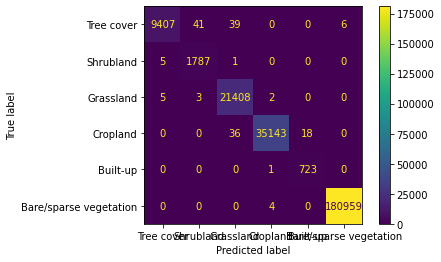

In [39]:
# Compute the confusion matrix - knn
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_knn)
#print(classification_report(test_labels, predictions_knn, target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

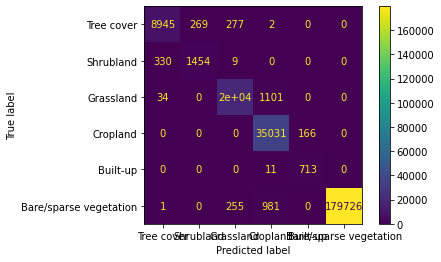

In [40]:
# Compute the confusion matrix - bayes
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_bayes)
#print(classification_report(test_labels, predictions_bayes,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

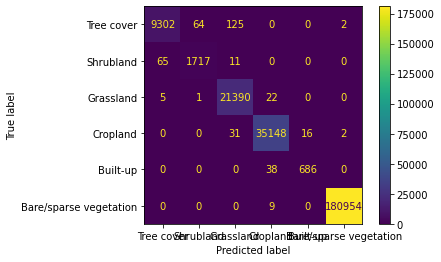

In [41]:
# Compute the confusion matrix - random forest
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_rf)
#print(classification_report(test_labels, predictions_rf,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()